In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import xarray as xr
import time as time
import pyarrow as pa
import dask.dataframe as dd
import dask.array as da
from dask.distributed import Client
import dask
import gc
import cartopy
import cartopy.crs as ccrs
import bottleneck
import haversine as hs
from mpl_toolkits.axes_grid1 import make_axes_locatable
import shapefile as shp

### Opening file

In [2]:
#opening coastline array into numpy array
sf = shp.Reader("data/GBR_adm0.shp")
shapes = sf.shapes()
coastline = np.array(shapes[0].points)

print(coastline.shape)
print(coastline[coastline[:,0]>-12,:].shape) #cuts out island at -13E
print(coastline[coastline[:,1]<59.5,:].shape) #cuts out island above 59N

coastline = coastline[coastline[:,0]>-12,:]
coastline = coastline[coastline[:,1]<59.5,:]

(416923, 2)
(416884, 2)
(406775, 2)


### Plotting Coastline

Text(0, 0.5, 'Latitude')

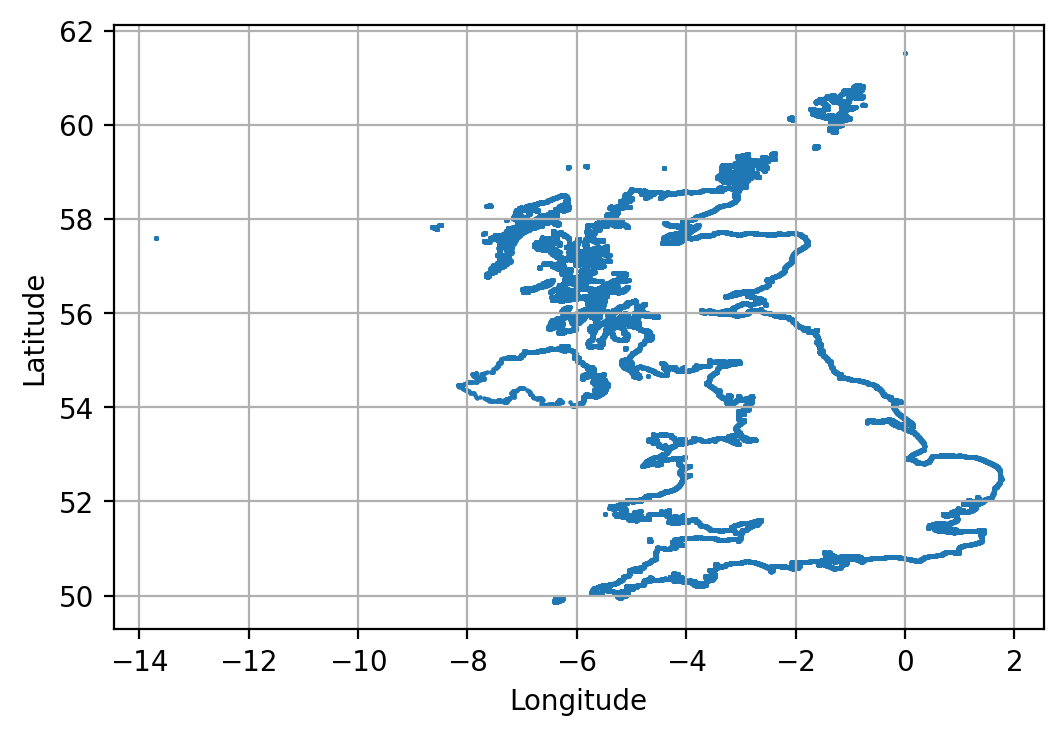

In [4]:
#plotting coastline
sf = shp.Reader("data/GBR_adm0.shp")
plt.figure(dpi=200)
for shape in sf.shapes():
    x = [i[0] for i in shape.points[:]]
    y = [i[1] for i in shape.points[:]]
    plt.scatter(x,y,s=0.4)
plt.grid()
plt.xlabel('Longitude')
plt.ylabel('Latitude')

### Defining haversine function

In [5]:
def haversine_np(lon1, lat1, lon2, lat2):
    """
    Calculate the great circle distance between two points
    on the earth (specified in decimal degrees)

    All args must be of equal length.    

    """
    lon1, lat1, lon2, lat2 = map(np.radians, [lon1, lat1, lon2, lat2])

    dlon = lon2 - lon1
    dlat = lat2 - lat1

    a = np.sin(dlat/2.0)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2.0)**2

    c = 2 * np.arcsin(np.sqrt(a))
    km = 6367 * c
    return km

### Creating distances array

In [229]:
N = coastline.shape[0]
lats = ds.variables['latitude'].values[:]
lons = ds.variables['longitude'].values[:]
distances = np.zeros((lats.shape[0],lons.shape[0]))
lons_grid, lats_grid = np.meshgrid(lons,lats)

start = time.time()
for i in range(lats.shape[0]):
    for j in range(lons.shape[0]):
        
        dist_arr = haversine_np(lons[j],lats[i],coastline[:,0],coastline[:,1]) 
        distances[i,j] = np.min(dist_arr)
end = time.time()
print('Time:',np.round(end-start,decimals=3),'secs')

Time: 45.104 secs


### Saving as Dataframe

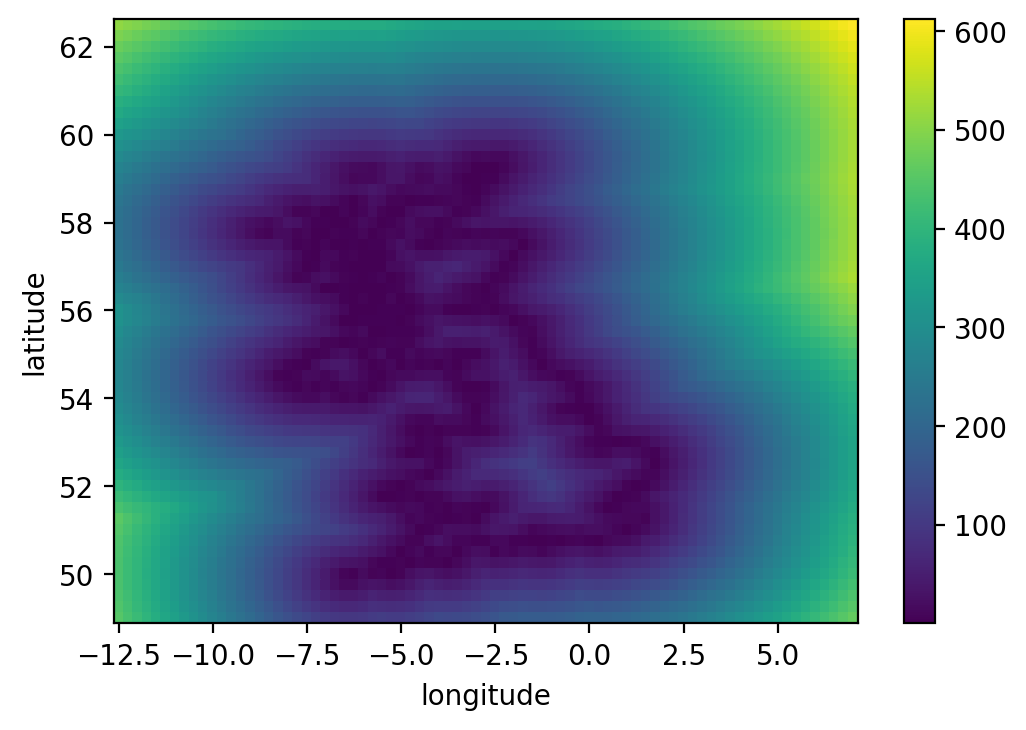

In [266]:
data_xr = xr.DataArray(distances, 
coords={'longitude': lons,'latitude': lats}, 
dims=["latitude", "longitude"])
data_xr.sel(latitude = 55, longitude = 0)
data_xr.to_netcdf(path="./data/netcdf/UK_coast_distances.nc")
plt.figure(dpi=200)
data_xr.plot()

## Checking if Point is in the UK

In [5]:
import shapefile
import fiona
pts = shapefile.Reader("data/GBR_adm0.shp")
polys = shapefile.Reader("data/GBR_adm0.shp")
points = [pt.shape.__geo_interface__ for pt in pts.shapeRecords()]
multi = shape(polys.shapeRecords()[0].shape.__geo_interface__) # 1 polygon
print(multi)

ModuleNotFoundError: No module named 'fiona'